In [2]:
import time
import scipy
import matplotlib.pyplot as plt
import matplotlib
import sys
import itertools
import json
import numpy as np
from odor_tracking_sim import utility
from pompy import models
# from matplotlib.widgets import Slider,Button
# from matplotlib.transforms import Bbox
from extras import UpdatingVPatch,plot_wedges
from core_functions import f0,f1,f1_wedge,f2,f3,f4,f5
from ipywidgets import interactive
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

TypeError: unhashable type: 'BboxTransformTo'

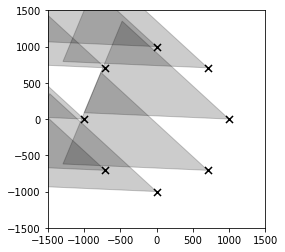

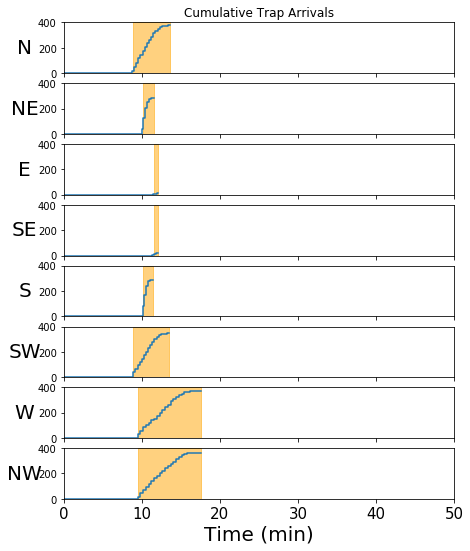

In [3]:
wind_angle = 7*scipy.pi/8.
# wind_angle = 9*scipy.pi/8.
# wind_angle =15*scipy.pi/16.
wind_mag = 1.0
num_flies = 20000
fly_speed = 1.6

initial_cone_angle = np.radians(20.)

release_times=0.

K = -.4
x_0 = 300


number_sources = 8
radius_sources = 1000.0
source_locations, _ = utility.create_circle_of_sources(number_sources,
                radius_sources,None)
source_pos = scipy.array([scipy.array(tup) for tup in source_locations])
release_location = np.zeros(2)

intended_heading_angles = np.random.uniform(0,2*np.pi,num_flies)
intended_heading_angles = np.linspace(0,2*np.pi,num_flies)

# Set up logistic prob plume object



#For visualization purposes for testing
xlim = (-1500., 1500.)
ylim = (-1500., 1500.)
im_extents = xlim[0], xlim[1], ylim[0], ylim[1]

fig1, ax = plt.subplots()
ax.set_ylim(list(ylim))
ax.set_xlim(list(xlim))
ax.set_aspect('equal')
for x,y in source_locations:

    #Black x
    plt.scatter(x,y,marker='x',s=50,c='k')

wedge_points = plot_wedges(source_pos,wind_angle,initial_cone_angle)
plume_wedges = [matplotlib.patches.Polygon(
    wedge_points[:,i,:],color='black',alpha=0.2) for i in range(number_sources)]

for plume_wedge in plume_wedges:
    ax.add_patch(plume_wedge)


#Convert intended heading angles to track heading angles
track_heading_angles,dispersing_speeds = f0(intended_heading_angles,wind_mag,
    wind_angle)

#Convert track_heading_angles to a list of plume intersection locations for each fly
intersection_distances,dispersal_distances = f1_wedge(
    track_heading_angles,source_pos,wind_angle,initial_cone_angle)
#Convert intersection_distances to probabilities
success_probabilities = f2(intersection_distances,K,x_0,source_pos,wind_angle)
# print('(flies x traps)')
# print(np.array2string(success_probabilities,precision=2))
#Convert probabilities to plume assignments
plume_assignments = f3(success_probabilities,dispersal_distances)

#Compute the time each fly intersected the plume it ended up detecting
dispersal_travel_times,release_to_chosen_plume_distances = f4(plume_assignments,dispersal_distances,dispersing_speeds)
#compute the time each fly arrived at the source of the plume it successfully chases
arrival_times,chasing_times,\
    which_flies,which_traps = f5(plume_assignments,dispersal_travel_times,
        intersection_distances,fly_speed,release_times)

num_bins = 50

trap_counts = scipy.zeros(8)
rasters = []

fig2 = plt.figure(figsize=(7, 11))

fig2.patch.set_facecolor('white')

labels = ['N','NE','E','SE','S','SW','W','NW']

sim_reorder = scipy.array([3,2,1,8,7,6,5,4])

# plt.ion()

#Simulated histogram
# for i in range(len(trap_num_list)):
axes = []
lines = []
cdf_patches = []
cdf_steepnesses = np.zeros(8)
first_hit_times = np.full(8,np.nan)
for i in range(8):

    row = sim_reorder[i]-1
    ax = plt.subplot2grid((10,1),(row,0))
    t_sim = arrival_times[which_traps==i]

    if len(t_sim)==0:
        ax.set_xticks([0,10,20,30,40,50])
        trap_total = 0
        pass
    else:
        t_sim = t_sim/60.
        # (n, bins, cdf_patches) = ax.hist(t_sim,num_bins,cumulative=True,
        # histtype='step',
        # range=(0,max(t_sim)))
        (n, bins) = np.histogram(t_sim,bins=num_bins,#cumulative=True,
            # histtype='step',
            range=(0,max(t_sim)))
        cum_n = np.cumsum(n)
        # line, = plt.plot(bins[:-1],cum_n,linewidth=1.)
        # line, = plt.plot(bins[1:],cum_n,linewidth=1.)
        # line, = plt.plot(bins,np.hstack((np.array([0,]),cum_n)),'o',linewidth=1.)
        line, = plt.step(bins,np.hstack((np.array([0,]),cum_n)))
        lines.append(line)
        # patch = plt.axvspan(min(t_sim),max(t_sim),alpha=0.5,color='orange')

        patch_object = UpdatingVPatch(min(t_sim),max(t_sim)-min(t_sim))
        ax.add_patch(patch_object.rectangle)
        cdf_patches.append(patch_object)

        # n = n/num_iterations
        # trap_total = int(sum(n))
        # trap_total = int(n[-1])
        try:
            trap_counts[i]=max(cum_n)
        except(IndexError):
            trap_counts[i]=0

        cdf_steepnesses[i] = trap_counts[i]/(max(t_sim)-min(t_sim))
        first_hit_times[i] = min(t_sim)


    if sim_reorder[i]-1==0:
        # ax.set_title('Cumulative Trap Arrivals \n  K: '+str(K)+', x_0: '+str(x_0))
        ax.set_title('Cumulative Trap Arrivals')

    ax.set_xlim([0,50])
    # plt.pause(0.001)
    # ax.set_yticks([ax.get_yticks()[0],ax.get_yticks()[-1]])
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)
    # ax.text(-0.1,0.5,str(trap_total),transform=ax.transAxes,fontsize=20,horizontalalignment='center')
    # ax.text(-0.01,1,trap_total,transform=ax.transAxes,fontsize=10,
    #     horizontalalignment='center',verticalalignment='center')
    ax.text(-0.1,0.5,str(labels[sim_reorder[i]-1]),transform=ax.transAxes,fontsize=20,
        horizontalalignment='center',verticalalignment='center')
    if sim_reorder[i]-1==7:
        ax.set_xlabel('Time (min)',x=0.5,horizontalalignment='center',fontsize=20)
        plt.tick_params(axis='x', which='major', labelsize=15)
    else:
        ax.set_xticklabels('')
    axes.append(ax)

for i,ax in enumerate(axes):
    # row = sim_reorder[i]-1
    # ax = plt.subplot2grid((8,1),(row,0))
    # ax.set_ylim([0,max(peak_counts)])
    ax.set_yticks([0,200,400,600,800])
    ax.set_ylim([0,400])
    patch_object = cdf_patches[i]
    patch_object.rectangle.set_height(ax.get_ylim()[1])

    # raw_input()


#This is setting up animation of the CDF with draggable
#(a) wind magnitude
#(b) K
#(c) x_0

plt.figure(fig2.number)

windmag_slider = widgets.FloatSlider(
    value=1.,
    min=0,
    max=4.0,
    step=0.1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# windmag_ax = plt.axes([.2, .05, 0.65, 0.03],transform=fig2.transFigure)
# windmag_slider = Slider(windmag_ax, 'Wind Mag', 0., 4.0, valinit=1.)

K_ax = plt.axes([.2, .1, 0.65, 0.03],transform=fig2.transFigure)
K_slider = Slider(K_ax , 'K', 0., 1.0, valinit=0.4)

x_0_ax = plt.axes([.2, .15, 0.65, 0.03],transform=fig2.transFigure)
x_0_slider = Slider(x_0_ax, 'x_0', 0., 1000.0, valinit=300.)

cone_angle_ax = plt.axes([.2, .0, 0.65, 0.03],transform=fig2.transFigure)
cone_angle_slider = Slider(cone_angle_ax, 'cone_width', 0., 40.0, valinit=np.degrees(initial_cone_angle)) #in degrees


reset_axis = plt.axes([.9, 0.075, 0.08, 0.03])
button = Button(reset_axis, 'Reset', color='purple', hovercolor='0.975')



#This is setting up the animated plot for the flies moving through space

scatter_currently_headings= True #False is the headings, True is the plume intersections

time = 5*60.
mag = time*dispersing_speeds
plt.figure(fig1.number)
fly_dots = plt.scatter(mag*np.cos(track_heading_angles),
    mag*np.sin(track_heading_angles),color='r',alpha=0.02)
plt.xticks([])
plt.yticks([])
axtime = plt.axes([.2, .0, 0.65, 0.03],transform=fig1.transFigure)
stime = Slider(axtime, 'Time', 0., 20.0, valinit=5.)

toggle_axis = plt.axes([.9, 0.075, 0.08, 0.03])
button1 = Button(toggle_axis, 'Headings/Intercepts', color='purple', hovercolor='0.975')



#Setting up figure 3, trap arrival histogram


steepness_max = 300.

num_traps = np.shape(source_pos)[0]

fig3 = plt.figure(3)
trap_locs = (2*np.pi/num_traps)*np.array(range(num_traps))

#Set 0s to 1 for plotting purposes
trap_counts[trap_counts==0] = .5

radius_scale = 0.3
plot_size = 1.5
ax = plt.subplot(aspect=1)
trap_locs_2d = [(scipy.cos(trap_loc),scipy.sin(trap_loc)) for trap_loc in trap_locs]

trap_patches = [plt.Circle(center, size,
    alpha=min(cdf_steepnesses[i]/steepness_max,1.)) for center, size, i in zip(
        trap_locs_2d, radius_scale*trap_counts/400.,range(8))]

for trap_patch in trap_patches:
    ax.add_patch(trap_patch)


# if max(trap_counts)>0.5:
#     coll.set(array=first_hit_times,cmap=cmap)
#     coll.set_clim(vmin=5.,vmax=20.)
#     fig3.colorbar(coll,pad=0.2)

vmin = 5.;vmax = 20.
trap_cmap_vals = (first_hit_times-vmin)/vmax
trap_cmap  = matplotlib.cm.get_cmap('plasma_r')
# trap_cmap.set_array([])


for trap_cmap_val,trap_patch in zip(trap_cmap_vals,trap_patches):
    # trap_patch.set_color(trap_cmap(trap_cmap_val)[:-1])
    color = tuple(np.array((trap_cmap(trap_cmap_val)[:-1])).astype(float).tolist())
    trap_patch.set_color(color)

ax.set_ylim([-plot_size,plot_size]);ax.set_xlim([-plot_size,plot_size])
ax.set_xticks([])
ax.set_xticklabels('')
ax.set_yticks([])
ax.set_yticklabels('')

coll = matplotlib.collections.PatchCollection(trap_patches)#, facecolors=colors,edgecolors=colors)
coll.set(cmap=trap_cmap,array=[])
coll.set_clim(vmin=vmin,vmax=vmax)
fig3.colorbar(coll,pad=0.2)
ax.text(2.1,.1,'First Arrival Time (min)',horizontalalignment='center',
    rotation=-90,verticalalignment='center',fontsize=15)

# fig3.colorbar(cmap,pad=0.2)


# ax.add_collection(coll)
# plt.colorbar()

# coll.set_alpha(cdf_steepnesses)


# plt.show()

# biggest_trap_loc = trap_locs_2d[
#     np.where(trap_counts==max(trap_counts))[0][0]]
#
# ax.text(biggest_trap_loc[0],biggest_trap_loc[1],
#     str(int(max(trap_counts))),horizontalalignment='center',
#         verticalalignment='center',fontsize=18,color='white')

#Wind arrow
plt.arrow(0.5, 0.5, 0.1*scipy.cos(wind_angle), 0.1*scipy.sin(wind_angle),transform=ax.transAxes,color='b',
    width=0.01,head_width=0.05)
# ax.text(0.55, 0.5,'Wind',transform=ax.transAxes,color='b')
ax.text(0,1.5,'N',horizontalalignment='center',verticalalignment='center',fontsize=25)
ax.text(0,-1.5,'S',horizontalalignment='center',verticalalignment='center',fontsize=25)
ax.text(1.5,0,'E',horizontalalignment='center',verticalalignment='center',fontsize=25)
ax.text(-1.5,0,'W',horizontalalignment='center',verticalalignment='center',fontsize=25)
# plt.title('Simulated')
fig3.patch.set_facecolor('white')
plt.axis('off')


def update(val):

    global scatter_currently_headings

    wind_mag = windmag_slider.val
    K = -1.*K_slider.val
    x_0 = x_0_slider.val
    cone_angle = np.radians(cone_angle_slider.val)
    track_heading_angles,dispersing_speeds = f0(intended_heading_angles,wind_mag,wind_angle)
    intersection_distances,dispersal_distances = f1_wedge(
        track_heading_angles,source_pos,wind_angle,cone_angle)

    success_probabilities = f2(intersection_distances,K,x_0,source_pos,wind_angle)
    plume_assignments = f3(success_probabilities,dispersal_distances)
    dispersal_travel_times,release_to_chosen_plume_distances = f4(
        plume_assignments,dispersal_distances,dispersing_speeds)
    arrival_times,chasing_times,\
        which_flies,which_traps = f5(plume_assignments,
            dispersal_travel_times,intersection_distances,fly_speed,release_times)


    #(1) Update the CDF figure
    new_maxes = 400*np.ones(8)
    trap_counts = np.zeros(8)
    first_hit_times = np.full(8,np.nan)

    for i in range(8):

        row = sim_reorder[i]-1
        ax = axes[i]
        t_sim = arrival_times[which_traps==i]/60.

        try:
            (n, bins) = np.histogram(t_sim,bins=num_bins,#cumulative=True,
                # histtype='step',
                range=(0,max(t_sim)))
            cum_n = np.cumsum(n)
            lines[i].set_ydata(np.hstack((np.array([0,]),cum_n)))
            lines[i].set_xdata(bins)

            new_maxes[i] = max(400.,50*np.ceil(max(cum_n)/50.))
            trap_counts[i]=max(cum_n)


        except(ValueError):
            lines[i].set_ydata(np.zeros_like(lines[i].get_ydata))
            trap_counts[i]=0

        patch_object = cdf_patches[i]
        try:
            patch_object.update(min(t_sim),max(t_sim)-min(t_sim))
            patch_object.rectangle.set_height(ax.get_ylim()[1])
            cdf_steepnesses[i] = trap_counts[i]/(max(t_sim)-min(t_sim))
            first_hit_times[i] = min(t_sim)
        except(ValueError):
            pass
        #print(patch_object.rectangle.get_x())
        #print('---------')



    for i,ax in enumerate(axes):
        ax.set_ylim([0,np.max(new_maxes)])

    #(2) update the fly heading display
    time = stime.val*60.


    if scatter_currently_headings:
        fly_dots.set_offsets(
            scipy.c_[
                time*dispersing_speeds*np.cos(track_heading_angles),
                time*dispersing_speeds*np.sin(track_heading_angles)])
    else:
        fly_dots.set_offsets(
            scipy.c_[
                release_to_chosen_plume_distances*np.cos(track_heading_angles),
                release_to_chosen_plume_distances*np.sin(track_heading_angles)])

    #(2a) update the plume wedges
    wedge_points = plot_wedges(source_pos,wind_angle,cone_angle)
    for i,wedge in enumerate(plume_wedges):
        wedge.set_xy(wedge_points[:,i,:])


    #(3) update the trap histogram figure

    trap_cmap_vals = (first_hit_times-vmin)/vmax
    # print('--------')
    # print(trap_cmap_vals)

    for i,trap_patch,trap_count in zip(range(8),trap_patches,trap_counts):
        trap_patch.set_radius(radius_scale*trap_count/max(new_maxes))
        trap_patch.set_alpha(min(cdf_steepnesses[i]/steepness_max,1.))
        color = tuple(np.array((trap_cmap(trap_cmap_vals[i])[:-1])).astype(float).tolist())
        # print(color)
        trap_patch.set_color(color)

    fig1.canvas.draw_idle()
    fig2.canvas.draw_idle()
    fig3.canvas.draw_idle()


windmag_slider.on_changed(update)
K_slider.on_changed(update)
x_0_slider.on_changed(update)
cone_angle_slider.on_changed(update)

def reset(event):
    windmag_slider.reset()
    K_slider.reset()
    x_0_slider.reset()
    cone_angle_slider.reset()
    stime.reset()

button.on_clicked(reset)

def toggle(event):

    global scatter_currently_headings
    K = -1.*K_slider.val
    x_0 = x_0_slider.val
    time = stime.val*60.

    wind_mag = windmag_slider.val
    cone_angle = np.radians(cone_angle_slider.val)
    track_heading_angles,dispersing_speeds = f0(intended_heading_angles,wind_mag,wind_angle)

    if scatter_currently_headings:

        intersection_distances,dispersal_distances = f1_wedge(
            track_heading_angles,source_pos,wind_angle,cone_angle)
        success_probabilities = f2(intersection_distances,K,x_0,source_pos,wind_angle)
        plume_assignments = f3(success_probabilities,dispersal_distances)
        dispersal_travel_times,release_to_chosen_plume_distances = f4(
            plume_assignments,dispersal_distances,dispersing_speeds)
        fly_dots.set_offsets(
            scipy.c_[
                release_to_chosen_plume_distances*np.cos(track_heading_angles),
                release_to_chosen_plume_distances*np.sin(track_heading_angles)])
        scatter_currently_headings = not(scatter_currently_headings)
    else:
        fly_dots.set_offsets(
            scipy.c_[
                time*dispersing_speeds*np.cos(track_heading_angles),
                time*dispersing_speeds*np.sin(track_heading_angles)])
        scatter_currently_headings = not(scatter_currently_headings)

    fig1.canvas.draw_idle()




button1.on_clicked(toggle)

def update1(val):

    wind_mag = windmag_slider.val
    track_heading_angles,dispersing_speeds = f0(intended_heading_angles,wind_mag,wind_angle)

    time = stime.val*60.
    fly_dots.set_offsets(
        scipy.c_[
            time*dispersing_speeds*np.cos(track_heading_angles),
            time*dispersing_speeds*np.sin(track_heading_angles)])
    fig1.canvas.draw_idle()


stime.on_changed(update1)


plt.show()


In [39]:
# interactive_plot = interactive(f, wind_mag = (0,3.,0.1))
# output = interactive_plot.children[-1]
# output.layout.height = '700px'
# interactive_plot

fig1,fig2,fig3 = interactive(f, wind_mag = (0,3.,0.1))
fig1


TypeError: cannot unpack non-iterable interactive object